Quick tutorial to explain how to create a environment with braitenberg vehicles equiped with selective sensors (still a draft so comments of the notebook won't be complete yet)

In [1]:
import logging as lg

from enum import Enum
from functools import partial
from typing import Tuple

import jax
import numpy as np
import jax.numpy as jnp

from jax import vmap, jit
from jax import random, ops, lax

from flax import struct
from jax_md.rigid_body import RigidBody
from jax_md import simulate 
from jax_md import space, rigid_body, partition, quantity

from vivarium.experimental.environments.utils import normal, distance 
from vivarium.experimental.environments.base_env import BaseState, BaseEnv
from vivarium.experimental.environments.physics_engine import total_collision_energy, friction_force, dynamics_fn
from vivarium.experimental.environments.braitenberg.simple import relative_position, proximity_map, sensor_fn, sensor
from vivarium.experimental.environments.braitenberg.simple import Behaviors, behavior_to_params, linear_behavior
from vivarium.experimental.environments.braitenberg.simple import lr_2_fwd_rot, fwd_rot_2_lr, motor_command
from vivarium.experimental.environments.braitenberg.simple import braintenberg_force_fn

2024-08-06 14:27:21.859650: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# Used for jax.debug.breakpoint in a jupyter notebook
class FakeStdin:
  def readline(self):
    return input()
  
# Usage : 
# jax.debug.breakpoint(backend="cli", stdin=FakeStdin())

# See this issue : https://github.com/google/jax/issues/11880

## Create the classes and helper functions

Add entity sensed type as a field in entities + sensed in agents. The agents sense the "sensed type" of the entities. In our case, there will be preys, predators, ressources and poison.

In [3]:

### Define the constants and the classes of the environment to store its state ###
SPACE_NDIMS = 2

class EntityType(Enum):
    AGENT = 0
    OBJECT = 1

# Already incorporates position, momentum, force, mass and velocity
@struct.dataclass
class EntityState(simulate.NVEState):
    entity_type: jnp.array
    ent_subtype: jnp.array
    entity_idx: jnp.array
    diameter: jnp.array
    friction: jnp.array
    exists: jnp.array
    
@struct.dataclass
class ParticleState:
    ent_idx: jnp.array
    color: jnp.array

@struct.dataclass
class AgentState(ParticleState):
    prox: jnp.array
    motor: jnp.array
    proximity_map_dist: jnp.array
    proximity_map_theta: jnp.array
    behavior: jnp.array
    params: jnp.array
    sensed: jnp.array
    wheel_diameter: jnp.array
    speed_mul: jnp.array
    max_speed: jnp.array
    theta_mul: jnp.array    
    proxs_dist_max: jnp.array
    proxs_cos_min: jnp.array

@struct.dataclass
class ObjectState(ParticleState):
    pass

@struct.dataclass
class State(BaseState):
    max_agents: jnp.int32
    max_objects: jnp.int32
    neighbor_radius: jnp.float32
    dt: jnp.float32  # Give a more explicit name
    collision_alpha: jnp.float32
    collision_eps: jnp.float32
    ent_sub_types: dict
    entities: EntityState
    agents: AgentState
    objects: ObjectState    

Define get_relative_displacement

In [4]:
# TODO : Should refactor the function to split the returns
def get_relative_displacement(state, agents_neighs_idx, displacement_fn):
    """Get all infos relative to distance and orientation between all agents and their neighbors

    :param state: state
    :param agents_neighs_idx: idx all agents neighbors
    :param displacement_fn: jax md function enabling to know the distance between points
    :return: distance array, angles array, distance map for all agents, angles map for all agents
    """
    body = state.entities.position
    senders, receivers = agents_neighs_idx
    Ra = body.center[senders]
    Rb = body.center[receivers]
    dR = - space.map_bond(displacement_fn)(Ra, Rb)  # Looks like it should be opposite, but don't understand why

    dist, theta = proximity_map(dR, body.orientation[senders])
    proximity_map_dist = jnp.zeros((state.agents.ent_idx.shape[0], state.entities.entity_idx.shape[0]))
    proximity_map_dist = proximity_map_dist.at[senders, receivers].set(dist)
    proximity_map_theta = jnp.zeros((state.agents.ent_idx.shape[0], state.entities.entity_idx.shape[0]))
    proximity_map_theta = proximity_map_theta.at[senders, receivers].set(theta)
    return dist, theta, proximity_map_dist, proximity_map_theta

to compute motors, only use linear behaviors (don't vmap it) because we vmap the functions to compute agents proxiemters and motors at a higher level 


In [5]:
def linear_behavior(proxs, params):
    """Compute the activation of motors with a linear combination of proximeters and parameters

    :param proxs: proximeter values of an agent
    :param params: parameters of an agent (mapping proxs to motor values)
    :return: motor values
    """
    return params.dot(jnp.hstack((proxs, 1.)))

def compute_motor(proxs, params, behaviors, motors):
    """Compute new motor values. If behavior is manual, keep same motor values. Else, compute new values with proximeters and params.

    :param proxs: proximeters of all agents
    :param params: parameters mapping proximeters to new motor values
    :param behaviors: array of behaviors
    :param motors: current motor values
    :return: new motor values
    """
    manual = jnp.where(behaviors == Behaviors.MANUAL.value, 1, 0)
    manual_mask = manual
    linear_motor_values = linear_behavior(proxs, params)
    motor_values = linear_motor_values * (1 - manual_mask) + motors * manual_mask
    return motor_values

## 1 : Add functions to compute the proximeters and motors of agents with occlusion

Logic for computing sensors and motors: 

- We get the raw proxs
- We get the ent types of the two detected entities (left and right)
- For each behavior, we updated the proxs according to the detected and the sensed entities (e.g sensed entities = [0, 1, 0 , 0] : only sense ent of type 1)
- We then compute the motor values for each behavior and do a mean of them 

Create functions to update the two proximeter of an agent for a specific behavior 

- We already have the two closest proximeters in this case
- We want to compute the value of motors associated to a behavior for these proxs
- We can sense different type of entities 
- The two proximeters are each associated to a specific entity type
- So if the specific entity type is detected, the proximeter value is kept 
- Else it is set to 0 so it won't have effect on the motor values 
- To do so we use a mask (mask of 1's, if an entity is detected we set it to 0 with a multiplication)
- So if the mask is already set to 0 (i.e the ent is detected), the masked value will still be 0 even if you multiply it by 1
- Then we update the proximeter values with a jnp.where

In [6]:
def update_mask(mask, left_n_right_types, ent_type):
    """Update a mask of 

    :param mask: mask that will be applied on sensors of agents
    :param left_n_right_types: types of left adn right sensed entities
    :param ent_type: entity subtype (e.g 1 for predators)
    :return: mask
    """
    cur = jnp.where(left_n_right_types == ent_type, 0, 1)
    mask *= cur
    return mask

def keep_mask(mask, left_n_right_types, ent_type):
    """Return the mask unchanged

    :param mask: mask
    :param left_n_right_types: left_n_right_types
    :param ent_type: ent_type
    :return: mask
    """
    return mask

def mask_proxs_occlusion(proxs, left_n_right_types, ent_sensed_arr):
    """Mask the proximeters of agents with occlusion

    :param proxs: proxiemters of agents without occlusion (shape = (2,))
    :param e_sensed_types: types of both entities sensed at left and right (shape=(2,))
    :param ent_sensed_arr: mask of sensed subtypes by the agent (e.g jnp.array([0, 1, 0, 1]) if sense only entities of subtype 1 and 4)
    :return: updated proximeters according to sensed_subtypes
    """
    mask = jnp.array([1, 1])
    # Iterate on the array of sensed entities mask
    for ent_type, sensed in enumerate(ent_sensed_arr):
        # If an entity is sensed, update the mask, else keep it as it is
        mask = jax.lax.cond(sensed, update_mask, keep_mask, mask, left_n_right_types, ent_type)
    # Update the mask with 0s where the mask is, else keep the prox value
    proxs = jnp.where(mask, 0, proxs)
    return proxs

# Example :
# ent_sensed_arr = jnp.array([0, 1, 0, 0, 1])
# proxs = jnp.array([0.8, 0.2])
# e_sensed_types = jnp.array([4, 4]) # Modify these values to check it works
# print(mask_proxs_occlusion(proxs, e_sensed_types, ent_sensed_arr))

Create a function to compute the motor values for a specific behavior 

- Convert the idx of the detected entitites (associated to the values of the two proximeters) into their types
- Mask their sensors with the function presented above 
- Compute the motors with the updated sensors

In [7]:
def compute_behavior_motors(state, params, sensed_mask, behavior, motor, agent_proxs, sensed_ent_idx):
    """_summary_

    :param state: state
    :param params: behavior params params
    :param sensed_mask: sensed_mask for this behavior
    :param behavior: behavior
    :param motor: motor values
    :param agent_proxs: agent proximeters (unmasked)
    :param sensed_ent_idx: idx of left and right entities sensed 
    :return: right motor values for this behavior 
    """
    left_n_right_types = state.entities.ent_subtype[sensed_ent_idx]
    behavior_proxs = mask_proxs_occlusion(agent_proxs, left_n_right_types, sensed_mask)
    motors = compute_motor(behavior_proxs, params, behaviors=behavior, motors=motor)
    return motors

# See for the vectorizing idx because already in a vmaped function here
compute_all_behavior_motors = vmap(compute_behavior_motors, in_axes=(None, 0, 0, 0, None, None, None))

In [8]:
def linear_behavior(proxs, params):
    """Compute the activation of motors with a linear combination of proximeters and parameters

    :param proxs: proximeter values of an agent
    :param params: parameters of an agent (mapping proxs to motor values)
    :return: motor values
    """
    return params.dot(jnp.hstack((proxs, 1.)))

def compute_motor(proxs, params, behaviors, motors):
    """Compute new motor values. If behavior is manual, keep same motor values. Else, compute new values with proximeters and params.

    :param proxs: proximeters of all agents
    :param params: parameters mapping proximeters to new motor values
    :param behaviors: array of behaviors
    :param motors: current motor values
    :return: new motor values
    """
    manual = jnp.where(behaviors == Behaviors.MANUAL.value, 1, 0)
    manual_mask = manual
    linear_motor_values = linear_behavior(proxs, params)
    motor_values = linear_motor_values * (1 - manual_mask) + motors * manual_mask
    return motor_values

Create a function to compute the motor values each agent

In [9]:
def compute_occlusion_proxs_motors(state, agent_idx, params, sensed, behaviors, motor, raw_proxs, ag_idx_dense_senders, ag_idx_dense_receivers):
    """_summary_

    :param state: state
    :param agent_idx: agent idx in entities
    :param params: params arrays for all agent's behaviors
    :param sensed: sensed mask arrays for all agent's behaviors
    :param behaviors: agent behaviors array
    :param motor: agent motors
    :param raw_proxs: raw_proximeters for all agents (shape=(n_agents * (n_entities - 1), 2))
    :param ag_idx_dense_senders: ag_idx_dense_senders to get the idx of raw proxs (shape=(2, n_agents * (n_entities - 1))
    :param ag_idx_dense_receivers: ag_idx_dense_receivers (shape=(n_agents, n_entities - 1))
    :return: _description_
    """
    behavior = jnp.expand_dims(behaviors, axis=1) 
    # Compute the neighbors idx of the agent and get its raw proximeters (of shape (n_entities -1 , 2))
    ent_ag_neighs_idx = ag_idx_dense_senders[agent_idx]
    agent_raw_proxs = raw_proxs[ent_ag_neighs_idx]

    # Get the max and arg max of these proximeters on axis 0, gives results of shape (2,)
    agent_proxs = jnp.max(agent_raw_proxs, axis=0)
    argmax = jnp.argmax(agent_raw_proxs, axis=0)
    # Get the real entity idx of the left and right sensed entities from dense neighborhoods
    sensed_ent_idx = ag_idx_dense_receivers[agent_idx][argmax]
    
    # Compute the motor values for all behaviors and do a mean on it
    motor_values = compute_all_behavior_motors(state, params, sensed, behavior, motor, agent_proxs, sensed_ent_idx)
    motors = jnp.mean(motor_values, axis=0)

    return agent_proxs, motors

compute_all_agents_proxs_motors_occl = vmap(compute_occlusion_proxs_motors, in_axes=(None, 0, 0, 0, 0, 0, None, None, None))

## 2 : Add functions to compute the proximeters and motors of agents without occlusion

Add Mask sensors and don't change functions

- mask_sensors: mask sensors according to sensed entity type for an agent
- don't change: return agent raw_proxs (surely return either the masked or the same prox array according to a sensed e type)

Then for each agent, we iterate on all of his behaviors. For each behavior, we iterate on each possible sensed entity type. If the entity is sensed, we keep the raw proximeters of the agent as they are currently. If it is not, we mask the proximeters of the specific (non sensed) entity type.

In [10]:
def mask_sensors(state, agent_raw_proxs, ent_type_id, ent_neighbors_idx):
    """Mask the raw proximeters of agents for a specific entity type 

    :param state: state
    :param agent_raw_proxs: raw_proximeters of agent (shape=(n_entities - 1), 2)
    :param ent_type_id: entity subtype id (e.g 0 for PREYS)
    :param ent_neighbors_idx: idx of agent neighbors in entities arrays
    :return: updated agent raw proximeters
    """
    mask = jnp.where(state.entities.ent_subtype[ent_neighbors_idx] == ent_type_id, 0, 1)
    mask = jnp.expand_dims(mask, 1)
    mask = jnp.broadcast_to(mask, agent_raw_proxs.shape)
    return agent_raw_proxs * mask

def dont_change(state, agent_raw_proxs, ent_type_id, ent_neighbors_idx):
    """Leave the agent raw_proximeters unchanged

    :param state: state
    :param agent_raw_proxs: agent_raw_proxs
    :param ent_type_id: ent_type_id
    :param ent_neighbors_idx: ent_neighbors_idx
    :return: agent_raw_proxs
    """
    return agent_raw_proxs

Add compute_behavior_prox, compute_behavior_proxs_motors, compute_agent_proxs_motors

- compute_behavior_prox: compute the proxs for one behavior (enumerate through all the sensed entities on this particular behavior)
- compute_behavior_proxs_motors: use fn above to compute the proxs and compute the motor values according to the behavior
- -vmap compute_all_behavior_proxs_motors:  computes this for all the behaviors of an agent
- compute_agent_proxs_motors: compute the proximeters and motor values of an agent for all its behaviors. Just return mean motor value
- -vmap compute_all_agents_proxs_motors: computes this for all agents (vmap over params, sensed and agent_raw_proxs) 

In [11]:
def compute_behavior_prox(state, agent_raw_proxs, ent_neighbors_idx, sensed_entities):
    """Compute the proximeters for a specific behavior

    :param state: state
    :param agent_raw_proxs: agent raw proximeters
    :param ent_neighbors_idx: idx of agent neighbors
    :param sensed_entities: array of sensed entities
    :return: updated proximeters
    """
    # iterate over all the types in sensed_entities and return if they are sensed or not
    for ent_type_id, sensed in enumerate(sensed_entities):
        # change the proxs if you don't perceive the entity, else leave them unchanged
        agent_raw_proxs = lax.cond(sensed, dont_change, mask_sensors, state, agent_raw_proxs, ent_type_id, ent_neighbors_idx)
    # Compute the final proxs with a max on the updated raw_proxs
    proxs = jnp.max(agent_raw_proxs, axis=0)
    return proxs

def compute_behavior_proxs_motors(state, params, sensed, behavior, motor, agent_raw_proxs, ent_neighbors_idx):
    """Return the proximeters and the motors for a specific behavior

    :param state: state
    :param params: params of the behavior
    :param sensed: sensed mask of the behavior
    :param behavior: behavior
    :param motor: motor values
    :param agent_raw_proxs: agent_raw_proxs
    :param ent_neighbors_idx: ent_neighbors_idx
    :return: behavior proximeters, behavior motors
    """
    behavior_prox = compute_behavior_prox(state, agent_raw_proxs, ent_neighbors_idx, sensed)
    behavior_motors = compute_motor(behavior_prox, params, behavior, motor)
    return behavior_prox, behavior_motors

# vmap on params, sensed and behavior (parallelize on all agents behaviors at once, but not motorrs because are the same)
compute_all_behavior_proxs_motors = vmap(compute_behavior_proxs_motors, in_axes=(None, 0, 0, 0, None, None, None))

def compute_agent_proxs_motors(state, agent_idx, params, sensed, behavior, motor, raw_proxs, ag_idx_dense_senders, ag_idx_dense_receivers):
    """Compute the agent proximeters and motors for all behaviors

    :param state: state
    :param agent_idx: idx of the agent in entities
    :param params: array of params for all behaviors
    :param sensed: array of sensed mask for all behaviors
    :param behavior: array of behaviors
    :param motor: motor values
    :param raw_proxs: raw_proximeters of all agents
    :param ag_idx_dense_senders: ag_idx_dense_senders to get the idx of raw proxs (shape=(2, n_agents * (n_entities - 1))
    :param ag_idx_dense_receivers: ag_idx_dense_receivers (shape=(n_agents, n_entities - 1))
    :return: array of agent_proximeters, mean of behavior motors
    """
    behavior = jnp.expand_dims(behavior, axis=1)
    ent_ag_idx = ag_idx_dense_senders[agent_idx]
    ent_neighbors_idx = ag_idx_dense_receivers[agent_idx]
    agent_raw_proxs = raw_proxs[ent_ag_idx]

    # vmap on params, sensed, behaviors and motorss (vmap on all agents)
    agent_proxs, agent_motors = compute_all_behavior_proxs_motors(state, params, sensed, behavior, motor, agent_raw_proxs, ent_neighbors_idx)
    mean_agent_motors = jnp.mean(agent_motors, axis=0)

    return agent_proxs, mean_agent_motors

compute_all_agents_proxs_motors = vmap(compute_agent_proxs_motors, in_axes=(None, 0, 0, 0, 0, 0, None, None, None))

Add classical braitenberg force fn

## Create the main environment class

In [12]:
@struct.dataclass
class Neighbors:
    neighbors: jnp.array
    agents_neighs_idx: jnp.array
    agents_idx_dense: jnp.array


#--- 4 Define the environment class with its different functions (step ...) ---#
class SelectiveSensorsEnv(BaseEnv):
    def __init__(self, state, occlusion=True, seed=42):
        """Init the selective sensors braitenberg env 

        :param state: simulation state already complete
        :param occlusion: wether to use sensors with occlusion or not, defaults to True
        :param seed: random seed, defaults to 42
        """
        self.seed = seed
        self.occlusion = occlusion
        self.compute_all_agents_proxs_motors = self.choose_agent_prox_motor_function()
        self.init_key = random.PRNGKey(seed)
        self.displacement, self.shift = space.periodic(state.box_size)
        self.init_fn, self.apply_physics = dynamics_fn(self.displacement, self.shift, braintenberg_force_fn)
        self.neighbor_fn = partition.neighbor_list(
            self.displacement, 
            state.box_size,
            r_cutoff=state.neighbor_radius,
            dr_threshold=10.,
            capacity_multiplier=1.5,
            format=partition.Sparse
        )
        self.neighbors_storage = self.allocate_neighbors(state)

    def distance(self, point1, point2):
        """Returns the distance between two points

        :param point1: point1 coordinates
        :param point2: point1 coordinates
        :return: distance between two points
        """
        return distance(self.displacement, point1, point2)
    
    # At the moment doesn't work because the _step function isn't recompiled 
    def choose_agent_prox_motor_function(self):
        """Returns the function to compute the proximeters and the motors with or without occlusion

        :return: compute_all_agents_proxs_motors function
        """
        if self.occlusion:
            prox_motor_function = compute_all_agents_proxs_motors_occl
        else:
            prox_motor_function = compute_all_agents_proxs_motors
        return prox_motor_function
    
    @partial(jit, static_argnums=(0,))
    def _step(self, state: State, neighbors_storage: Neighbors) -> Tuple[State, jnp.array]:
        """Do 1 jitted step in the environment and return the updated state

        :param state: current state
        :param neighbors_storage: class storing all neighbors information
        :return: new sttae
        """

        # Retrieve different neighbors format
        neighbors = neighbors_storage.neighbors
        agents_neighs_idx = neighbors_storage.agents_neighs_idx
        ag_idx_dense = neighbors_storage.agents_idx_dense
        # Differences : compute raw proxs for all agents first 
        dist, relative_theta, proximity_dist_map, proximity_dist_theta = get_relative_displacement(state, agents_neighs_idx, displacement_fn=self.displacement)
        senders, receivers = agents_neighs_idx

        dist_max = state.agents.proxs_dist_max[senders]
        cos_min = state.agents.proxs_cos_min[senders]
        target_exist_mask = state.entities.exists[agents_neighs_idx[1, :]]
        raw_proxs = sensor_fn(dist, relative_theta, dist_max, cos_min, target_exist_mask)

        # Could even just pass ag_idx_dense in the fn and do this inside
        ag_idx_dense_senders, ag_idx_dense_receivers = ag_idx_dense

        agent_proxs, mean_agent_motors = self.compute_all_agents_proxs_motors(
            state,
            state.agents.ent_idx,
            state.agents.params,
            state.agents.sensed,
            state.agents.behavior,
            state.agents.motor,
            raw_proxs,
            ag_idx_dense_senders,
            ag_idx_dense_receivers,
        )

        agents = state.agents.replace(
            prox=agent_proxs, 
            proximity_map_dist=proximity_dist_map, 
            proximity_map_theta=proximity_dist_theta,
            motor=mean_agent_motors
        )

        # Last block unchanged
        state = state.replace(agents=agents)
        entities = self.apply_physics(state, neighbors)
        state = state.replace(time=state.time+1, entities=entities)
        neighbors = neighbors.update(state.entities.position.center)

        return state, neighbors
    
    def step(self, state: State) -> State:
        """Do 1 step in the environment and return the updated state. This function also handles the neighbors mechanism and hence isn't jitted

        :param state: current state
        :return: next state
        """
        # Because momentum is initialized to None, need to initialize it with init_fn from jax_md
        if state.entities.momentum is None:
             state = self.init_fn(state, self.init_key)
            
        # Compute next state
        current_state = state
        state, neighbors = self._step(current_state, self.neighbors_storage)

        # Check if neighbors buffer overflowed
        if neighbors.did_buffer_overflow:
            # reallocate neighbors and run the simulation from current_state
            lg.warning(f'NEIGHBORS BUFFER OVERFLOW at step {state.time}: rebuilding neighbors')
            self.neighbors_storage = self.allocate_neighbors(state)
            assert not neighbors.did_buffer_overflow

        return state

    def allocate_neighbors(self, state, position=None):
        """Allocate the neighbors according to the state

        :param state: state
        :param position: position of entities in the state, defaults to None
        :return: Neighbors object with neighbors (sparse representation), idx of agent's neighbors, neighbors (dense representation) 
        """
        # get the sparse representation of neighbors (shape=(n_neighbors_pairs, 2))
        position = state.entities.position.center if position is None else position
        neighbors = self.neighbor_fn.allocate(position)

        # Also update the neighbor idx of agents
        ag_idx = state.entities.entity_type[neighbors.idx[0]] == EntityType.AGENT.value
        agents_neighs_idx = neighbors.idx[:, ag_idx]

        # Give the idx of the agents in sparse representation, under a dense representation (used to get the raw proxs in compute motors function)
        agents_idx_dense_senders = jnp.array([jnp.argwhere(jnp.equal(agents_neighs_idx[0, :], idx)).flatten() for idx in jnp.arange(state.max_agents)]) 
        # Note: jnp.argwhere(jnp.equal(self.agents_neighs_idx[0, :], idx)).flatten() ~ jnp.where(agents_idx[0, :] == idx)
        
        # Give the idx of the agent neighbors in dense representation
        agents_idx_dense_receivers = agents_neighs_idx[1, :][agents_idx_dense_senders]
        agents_idx_dense = agents_idx_dense_senders, agents_idx_dense_receivers

        neighbor_storage = Neighbors(neighbors=neighbors, agents_neighs_idx=agents_neighs_idx, agents_idx_dense=agents_idx_dense)
        return neighbor_storage
    


## Create the state

In [19]:
seed = 0
n_dims = 2
box_size = 100
diameter = 5.0
friction = 0.1
mass_center = 1.0
mass_orientation = 0.125
neighbor_radius = 100.0
collision_alpha = 0.5
collision_eps = 0.1
dt = 0.1
wheel_diameter = 2.0
speed_mul = 1.0
max_speed = 10.0
theta_mul = 1.0
prox_dist_max = 40.0
prox_cos_min = 0.0
existing_agents = None
existing_objects = None

# Define number of agents and objects
entities_sbutypes = ['PREYS', 'PREDS', 'RESSOURCES', 'POISON']
n_preys, preys_color = 5, 'blue'
n_preds, preds_color = 5, 'red'
n_ressources, ressources_color = 5, 'green'
n_poison, poison_color = 5, 'purple'
max_agents = n_preys + n_preds
max_objects = n_ressources + n_poison

# TODO : Will later use this data structure
preys_data = {
    'type': 'AGENT',
    'num': n_preys,
    'color': 'blue',
    'selective_behaviors': {
        'love': {
            'beh': 'LOVE',
            'sensed': ['PREDS', 'RESSOURCES']
        },
        'fear': {
            'beh': 'FEAR',
            'sensed': ['PREDS', 'POISON']
        }
    }
}

preds_data = {
    'type': 'AGENT',
    'num': 5,
    'color': 'red',
    'selective_behaviors': {
        'aggr': {
            'beh': 'AGGRESSION',
            'sensed': ['PREYS']
        },
        'fear': {
            'beh': 'FEAR',
            'sensed': ['POISON']
        }
    }
}

ressources_data = {
    'type': 'OBJECT',
    'num': 5,
    'color': 'green'
}

poison_data = {
    'type': 'OBJECT',
    'num': 5,
    'color': 'purple'
}

# Define the simulation data structure
entities_data = {
    'EntitySubTypes': entities_sbutypes,
    'Entities': {
        'PREYS': preys_data,
        'PREDS': preds_data,
        'RESSOURCES': ressources_data,
        'POISON': poison_data
    }
}

In [20]:
ent_sub_types_list = [['PREY', 5], ['PRED', 5], ['RESSOURCE', 5], ['POISON', 5]]
ent_sub_types = {t[0]: [i, t[1]] for i, t in enumerate(ent_sub_types_list)}
print(ent_sub_types)

key = random.PRNGKey(seed)
key, key_agents_pos, key_objects_pos, key_orientations = random.split(key, 4)

{'PREY': [0, 5], 'PRED': [1, 5], 'RESSOURCE': [2, 5], 'POISON': [3, 5]}


In [21]:
for k, v in ent_sub_types.items():
    print(k, v)

PREY [0, 5]
PRED [1, 5]
RESSOURCE [2, 5]
POISON [3, 5]


### Entities

Compared to simple Braitenberg env, just need to add a field ent_subtypes. So just need to add 1 more field in the init fn that either takes a list or ints as arguments (in case of ints care because we need to differentiate objects and agents ... --> But in classical case all the agents sense any entity the same, so lets not care abt it) 

In [22]:
def init_entities(
    max_agents=max_agents,
    max_objects=max_objects,
    n_dims=n_dims,
    box_size=box_size,
    existing_agents=None,
    existing_objects=None,
    mass_center=mass_center,
    mass_orientation=mass_orientation,
    diameter=diameter,
    friction=friction,
    # TODO
    ent_sub_types=ent_sub_types,
    key_agents_pos=random.PRNGKey(seed),
    key_objects_pos=random.PRNGKey(seed+1),
    key_orientations=random.PRNGKey(seed+2)
):

    existing_agents = max_agents if not existing_agents else existing_agents
    existing_objects = max_objects if not existing_objects else existing_objects

    n_entities = max_agents + max_objects # we store the entities data in jax arrays of length max_agents + max_objects 
    # Assign random positions to each entity in the environment
    agents_positions = random.uniform(key_agents_pos, (max_agents, n_dims)) * box_size
    objects_positions = random.uniform(key_objects_pos, (max_objects, n_dims)) * box_size
    positions = jnp.concatenate((agents_positions, objects_positions))
    # Assign random orientations between 0 and 2*pi to each entity
    orientations = random.uniform(key_orientations, (n_entities,)) * 2 * jnp.pi
    # Assign types to the entities
    agents_entities = jnp.full(max_agents, EntityType.AGENT.value)
    object_entities = jnp.full(max_objects, EntityType.OBJECT.value)
    entity_types = jnp.concatenate((agents_entities, object_entities), dtype=int)
    # Define arrays with existing entities
    exists_agents = jnp.concatenate((jnp.ones((existing_agents)), jnp.zeros((max_agents - existing_agents))))
    exists_objects = jnp.concatenate((jnp.ones((existing_objects)), jnp.zeros((max_objects - existing_objects))))
    exists = jnp.concatenate((exists_agents, exists_objects), dtype=int)

    # Works because dictionaries are ordered in Python
    ent_subtypes = np.zeros(n_entities)
    cur_idx = 0
    for subtype_id, n_subtype in ent_sub_types.values():
        ent_subtypes[cur_idx:cur_idx+n_subtype] = subtype_id
        cur_idx += n_subtype
    ent_subtypes = jnp.array(ent_subtypes, dtype=int) 
    print(ent_subtypes)

    return EntityState(
        position=RigidBody(center=positions, orientation=orientations),
        momentum=None,
        force=RigidBody(center=jnp.zeros((n_entities, 2)), orientation=jnp.zeros(n_entities)),
        mass=RigidBody(center=jnp.full((n_entities, 1), mass_center), orientation=jnp.full((n_entities), mass_orientation)),
        entity_type=entity_types,
        ent_subtype=ent_subtypes,
        entity_idx = jnp.array(list(range(max_agents)) + list(range(max_objects))),
        diameter=jnp.full((n_entities), diameter),
        friction=jnp.full((n_entities), friction),
        exists=exists
    )

entities = init_entities(ent_sub_types=ent_sub_types)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]


### Agents

Now this section becomes rly different. Need to have several behaviors for each agent (or an array of 1 behavior at minimum). Is the better choice to create a different w different functions in the step according to if you are in selective sensing / classic braitenberg mode ? Idk, would argue the second one is cleaner and also enables to simplify init functions. 

Preys:

- Love: other preys and ressources
- Fear: predators and poison
- Color: Blue

Predators:

- Aggression: preys
- Fear: Poison
- Color: Red

In [23]:
def define_behavior_map(behavior, sensed_mask):
    params = behavior_to_params(behavior)
    sensed_mask = jnp.array([sensed_mask])

    behavior_map = {
        'behavior': behavior,
        'params': params,
        'sensed_mask': sensed_mask
    }
    return behavior_map

In [24]:
def stack_behaviors(behaviors_dict_list):
    # init variables
    n_behaviors = len(behaviors_dict_list)
    sensed_length = behaviors_dict_list[0]['sensed_mask'].shape[1]

    params = np.zeros((n_behaviors, 2, 3)) # (2, 3) = params.shape
    sensed_mask = np.zeros((n_behaviors, sensed_length))
    behaviors = np.zeros((n_behaviors,))

    # iterate in the list of behaviors and update params and mask
    for i in range(n_behaviors):
        assert behaviors_dict_list[i]['sensed_mask'].shape[1] == sensed_length
        params[i] = behaviors_dict_list[i]['params']
        sensed_mask[i] = behaviors_dict_list[i]['sensed_mask']
        behaviors[i] = behaviors_dict_list[i]['behavior']

    stacked_behavior_map = {
        'behaviors': behaviors,
        'params': params,
        'sensed_mask': sensed_mask
    }

    return stacked_behavior_map

In [25]:
def get_agents_params_and_sensed_arr(agents_stacked_behaviors_list):
    n_agents = len(agents_stacked_behaviors_list)
    params_shape = agents_stacked_behaviors_list[0]['params'].shape
    sensed_shape = agents_stacked_behaviors_list[0]['sensed_mask'].shape
    behaviors_shape = agents_stacked_behaviors_list[0]['behaviors'].shape
    # Init arrays w right shapes
    params = np.zeros((n_agents, *params_shape))
    sensed = np.zeros((n_agents, *sensed_shape))
    behaviors = np.zeros((n_agents, *behaviors_shape))

    for i in range(n_agents):
        assert agents_stacked_behaviors_list[i]['params'].shape == params_shape
        assert agents_stacked_behaviors_list[i]['sensed_mask'].shape == sensed_shape
        assert agents_stacked_behaviors_list[i]['behaviors'].shape == behaviors_shape
        params[i] = agents_stacked_behaviors_list[i]['params']
        sensed[i] = agents_stacked_behaviors_list[i]['sensed_mask']
        behaviors[i] = agents_stacked_behaviors_list[i]['behaviors']

    params = jnp.array(params)
    sensed = jnp.array(sensed)
    behaviors = jnp.array(behaviors)

    return params, sensed, behaviors

In [26]:
# Prey behavior maps
prey_love = define_behavior_map(Behaviors.LOVE.value, [1, 0, 1, 0])
prey_fear = define_behavior_map(Behaviors.FEAR.value, [0, 1, 0, 1])

# Pred behavior maps
pred_aggr = define_behavior_map(Behaviors.AGGRESSION.value, [1, 0, 0, 0])
pred_fear = define_behavior_map(Behaviors.FEAR.value, [0, 0, 0, 1])

# Stack the behaviors for pred and preys
prey_behaviors_list = [prey_love, prey_fear]
prey_behaviors = stack_behaviors(prey_behaviors_list)

pred_behaviors_list = [pred_aggr, pred_fear]
pred_behaviors = stack_behaviors(pred_behaviors_list)

# Build a list with the stacked behaviors of all agents
agents_stacked_behaviors_list = [prey_behaviors] * n_preys + [pred_behaviors] * n_preds
params, sensed, behaviors = get_agents_params_and_sensed_arr(agents_stacked_behaviors_list)

prey_color = jnp.array([0., 0., 1.])
pred_color = jnp.array([1., 0., 0.])

prey_color=jnp.tile(prey_color, (n_preys, 1))
pred_color=jnp.tile(pred_color, (n_preds, 1))

agent_colors = jnp.concatenate([
    prey_color,
    pred_color
])


agents =  AgentState(
    # idx in the entities (ent_idx) state to map agents information in the different data structures
    ent_idx=jnp.arange(max_agents, dtype=int), 
    prox=jnp.zeros((max_agents, 2)),
    motor=jnp.zeros((max_agents, 2)),
    behavior=behaviors,
    params=params,
    sensed=sensed,
    wheel_diameter=jnp.full((max_agents), wheel_diameter),
    speed_mul=jnp.full((max_agents), speed_mul),
    max_speed=jnp.full((max_agents), max_speed),
    theta_mul=jnp.full((max_agents), theta_mul),
    proxs_dist_max=jnp.full((max_agents), prox_dist_max),
    proxs_cos_min=jnp.full((max_agents), prox_cos_min),
    proximity_map_dist=jnp.zeros((max_agents, 1)),
    proximity_map_theta=jnp.zeros((max_agents, 1)),
    color=agent_colors
)

### Objects

Nothing to add to init functions.

Ressources

- Color: green

Poison

- Color: purple

In [27]:
# Entities idx of objects
start_idx, stop_idx = max_agents, max_agents + max_objects 
objects_ent_idx = jnp.arange(start_idx, stop_idx, dtype=int)

res_color = jnp.array([0., 1., 0.])
pois_color = jnp.array([1., 0., 1.])

res_color=jnp.tile(res_color, (n_preys, 1))
pois_color=jnp.tile(pois_color, (n_preds, 1))

objects_colors = jnp.concatenate([
    res_color,
    pois_color
])

objects =  ObjectState(
    ent_idx=objects_ent_idx,
    color=objects_colors
)

### State

In [28]:
state =  State(
    time=0,
    box_size=box_size,
    max_agents=max_agents,
    max_objects=max_objects,
    neighbor_radius=neighbor_radius,
    collision_alpha=collision_alpha,
    collision_eps=collision_eps,
    dt=dt,
    entities=entities,
    agents=agents,
    objects=objects,
    ent_sub_types=ent_sub_types
)   

## Test the simulation

In [29]:
from vivarium.experimental.environments.braitenberg.render import render, render_history

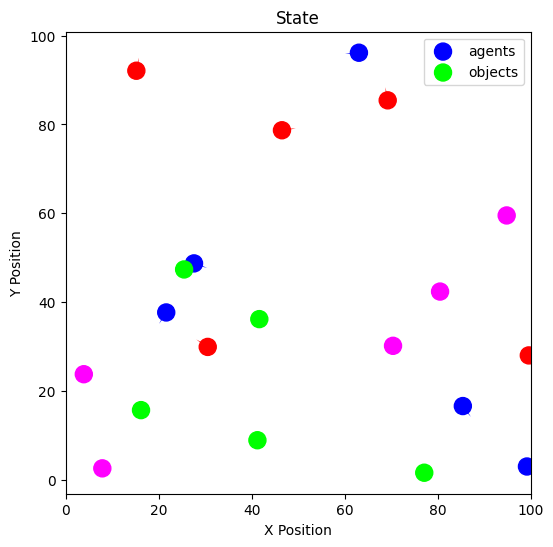

In [30]:
render(state)

In [31]:
env = SelectiveSensorsEnv(state, occlusion=True)

### Autonomous behaviors

In [32]:
n_steps = 5_000
hist = []

for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

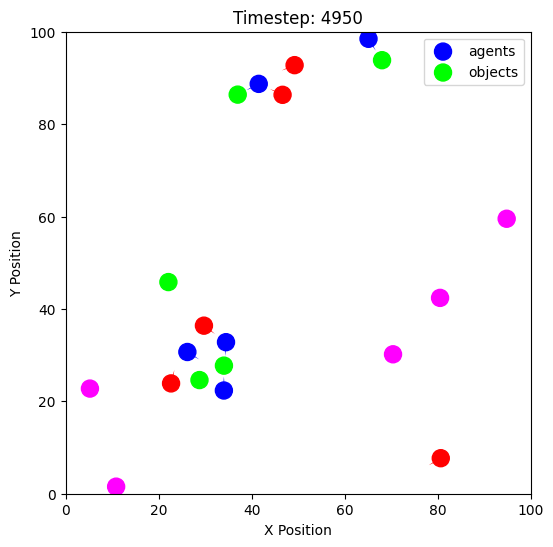

In [34]:
render_history(hist, skip_frames=50)

### Test manual behavior for an agent

Need to set all of its behaviors to manual.

In [35]:
ag_idx = 9
manual_behaviors = jnp.array([Behaviors.MANUAL.value, Behaviors.MANUAL.value,])
manual_color = jnp.array([0., 0., 0.])
manual_motors = jnp.array([1., 1.])

behaviors = state.agents.behavior.at[ag_idx].set(manual_behaviors)
colors = state.agents.color.at[ag_idx].set(manual_color)
motors = state.agents.motor.at[ag_idx].set(manual_motors)

agents = state.agents.replace(behavior=behaviors, color=colors, motor=motors)
state = state.replace(agents=agents)

In [36]:
hist = []

for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

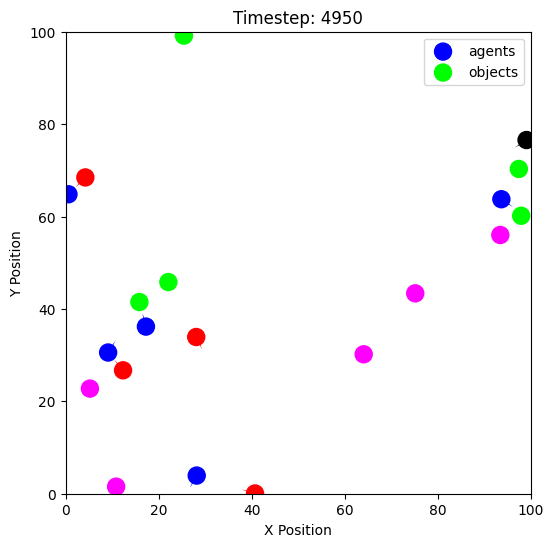

In [37]:
render_history(hist, skip_frames=50)